# Imports

In [25]:
import torch
import pandas as pd
from scipy.spatial.distance import cosine
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

In [27]:
training_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device=training_device
device

device(type='cuda')

In [28]:
df_train=pd.read_csv("/kaggle/input/aml-dataset/cf_train.csv")
df_test=pd.read_csv("/kaggle/input/aml-dataset/cf_test.csv")
encoding_map = {0: 0, 0.25: 1, 0.5: 2, 0.75: 3, 1: 4}

# Define a function to map the values to classes
def encode_to_classes(value):
    for key, val in encoding_map.items():
        if value == key:
            return val
    return None  # return None if value doesn't match any key

# Apply the function to create a new column with encoded classes
df_train['target_10_val'] = df_train['target_10_val'].apply(encode_to_classes)
df_test['target_10_val'] = df_test['target_10_val'].apply(encode_to_classes)

# Custom Dataloader

In [30]:
class CustomDataset:
    def __init__(self,dataframe,batch_size,device =training_device,shuffle=False):
        self.df=dataframe
        self.batch_size=batch_size
        self.columns_to_drop=['row_num','day','era','target_10_val','target_5_val','sigma','day_no']
        self.X = self.df.drop(self.columns_to_drop, axis=1)
        self.y=self.df['target_10_val']
        self.device=device
        self.shuffle=shuffle

    def generate_batches_with_labels(self,start_idx,end_idx):
        data=self.X.iloc[start_idx:end_idx]
        labels=self.y.iloc[start_idx:end_idx]
        dataset =  torch.utils.data.TensorDataset(torch.tensor(data.values),torch.tensor(labels.values))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=self.shuffle)
        # data_unseen = self.X.iloc[max(0,idx-9):idx+1]
        # labels_unseen=self.y.iloc[max(0,idx-9):idx+1]
        # data_unseen,labels_unseen = torch.tensor(data_unseen.values).to(self.device),torch.tensor(labels_unseen.values).to(self.device)
        return dataloader
        

In [11]:
customDS_train = CustomDataset(df_train,1024,shuffle = False)
customDS_test = CustomDataset(df_test,1024,shuffle = False)

# Model

In [13]:
class NAL_MLP(torch.nn.Module):
    def __init__(self, modules, hidden_dim, output_dim):
        super(NAL_MLP, self).__init__()
        modules = torch.nn.ModuleList([m for m in modules])
        self.layers = torch.nn.Sequential(*modules)
        self.att_layer=torch.nn.Linear(hidden_dim,1)
        self.softmax=torch.nn.Softmax()
        self.relu = torch.nn.ReLU()
        self.lastlinear =torch.nn.Linear(hidden_dim,output_dim)
        self.sigm =torch.nn.Sigmoid()
    
    def forward(self, x):
        x = self.layers(x)
        y_hat = self.lastlinear(x)
        y_hat = self.softmax(y_hat)
        h = self.att_layer(x)
        h=  self.sigm(h)
        return y_hat,h

In [14]:
class CustomLoss(torch.nn.Module):
    def __init__(self, reg, no_of_class=12):
        super(CustomLoss, self).__init__()
        self.reg = reg
        self.no_of_class = no_of_class

    def forward(self, inputs, targets):
        p = torch.Tensor(inputs[0]).to(device).t()

        targets = torch.eye(self.no_of_class).to(device)[targets].t()
        tou = torch.Tensor(inputs[1]).to(device)
        tou = tou.t()

        loss_a = torch.t(targets) @ torch.log(tou * (p - targets) + targets)
        loss_b = self.reg * torch.log(tou)
        loss_a = loss_a.diag().t()

        loss = loss_a + loss_b

        return -loss.mean()

    def custom_p(p):
        return p

In [40]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10,verbose=True):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            _, predicted = torch.max(outputs[0], 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        if val_loader is None:
            continue
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs[0], 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
    if val_loader is not None:
        plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
    if val_loader is not None:
        plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

In [42]:
len(df_train)

62400

# train Experts

In [45]:
def train_experts(no_of_experts):
    len_of_individual_train=len(df_train)//no_of_experts
    start=[i*len_of_individual_train for i in range(no_of_experts)]
    for i in range(len(start)):
        if i==len(start)-1:
            train_loader=customDS_train.generate_batches_with_labels(start[i],len(df_train))
        else:
            train_loader=customDS_train.generate_batches_with_labels(start[i],start[i+1])
        modules = [torch.nn.Linear(24,64),torch.nn.ReLU(),torch.nn.Linear(64,128),torch.nn.ReLU(),torch.nn.Linear(128,64),torch.nn.ReLU()]
        Model = NAL_MLP(modules,64,5)
        Model = Model.to(device)
        optimizer = torch.optim.Adam(Model.parameters(), lr=0.001)
        train_model(Model,CustomLoss(5,no_of_class=5), optimizer,train_loader, None,num_epochs=50)
        PATH="noisy_expert_no_"+str(i+1)+".pt"
        torch.save(Model, PATH)
    print("EVERYTHING COMPLETED SUCCESSFULLY")

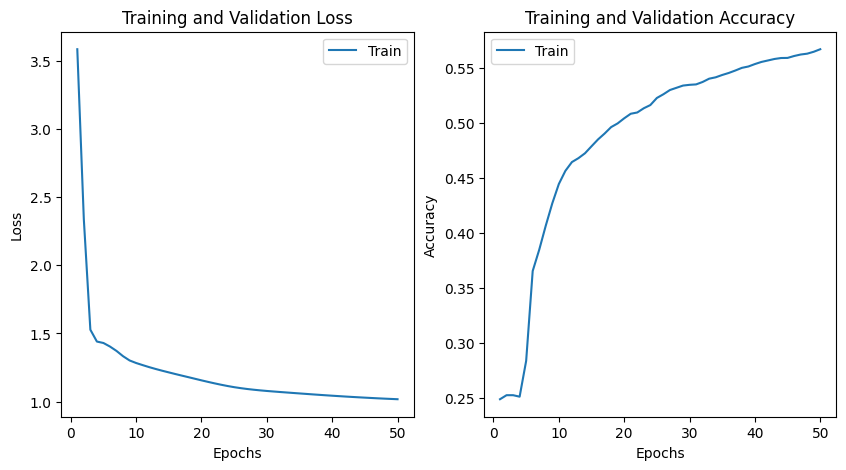

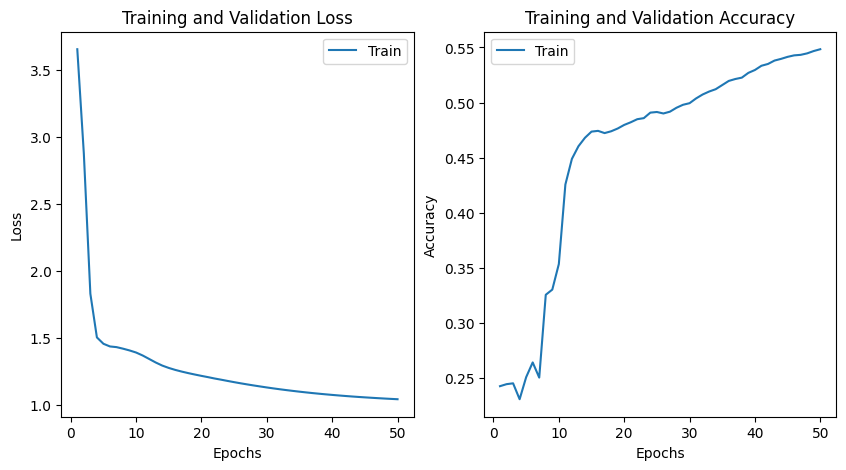

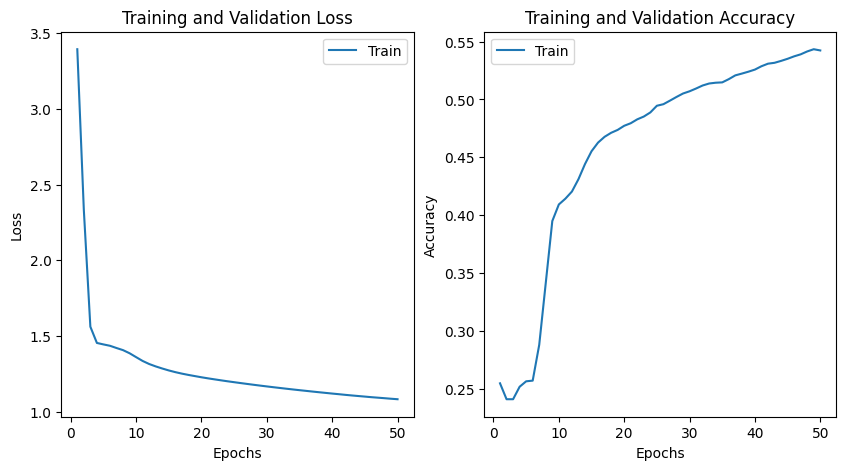

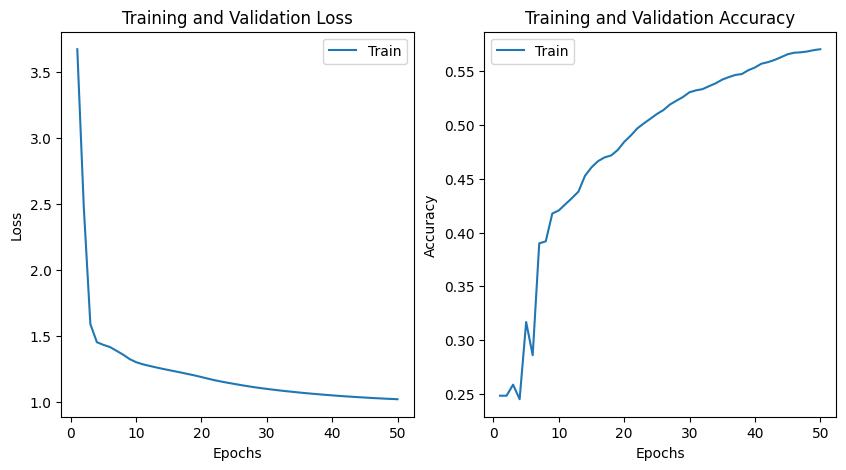

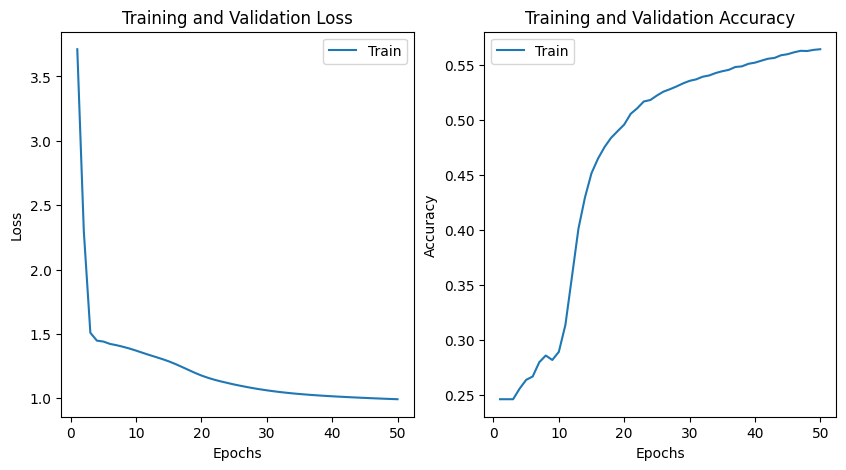

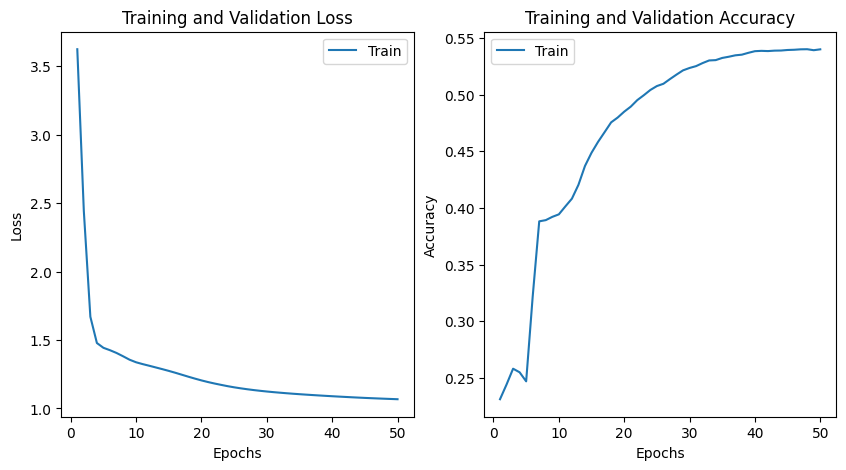

EVERYTHING COMPLETED SUCCESSFULLY


In [47]:
train_experts(6)

In [71]:
def winnow(no_of_experts):
    experts=[]
    weights=[]
    balance=[]
    for i in range(no_of_experts):
        model=torch.load("noisy_expert_no_"+str(i+1)+".pt")
        model.eval()
        experts.append(model)
        weights.append(1)
        balance.append(0)
    increase_count=0
    reduce_count=0
    # winnow majority on all of datasets
    train_loader=customDS_train.generate_batches_with_labels(0,len(df_train))
    for inputs,labels in tqdm(train_loader):
#         print(inputs.shape)
        for i in range(len(inputs)):
            predictions=[-99999,-99999,-99999,-99999,-99999]
            dict_of_predictions={0:[],1:[],2:[],3:[],4:[]}
            
            # Gathering Predictions
            for j in range(len(experts)):
                model=experts[j]
                input_copy = inputs[i].unsqueeze(0).clone()
                output=model(input_copy.to(device).to(torch.float32))
                _, predicted = torch.max(output[0], 1)
                predicted=int(predicted)
                predictions[predicted]=max(predictions[predicted],balance[j])
                dict_of_predictions[predicted].append(j)

            result_pred=predictions.index(max(predictions))
            correct_result=int(labels[i])
            # reducing/increasing weights only if prediction wrong
            if result_pred!=correct_result:
                # increasing Correct weights by 2
                for w in dict_of_predictions[correct_result]:
                    weights[w]=weights[w]*2
                    balance[w]+=1
                    increase_count+=1
                    
                # decreasing incorrect weights by 2
                for incorr_label in range(5):
                    if incorr_label!=correct_result:
                        for w in dict_of_predictions[incorr_label]:
                                weights[w]=weights[w]/2
                                balance[w]-=1
                                reduce_count+=1
        print("After Batch",weights)
        print("After Batch balance",balance)
        print("increased",increase_count,"Reduced",reduce_count)
    with open('weights_noisy.pkl', 'wb') as f:
        pickle.dump(weights, f)
    return weights

In [73]:
weights=winnow(6)

  2%|▏         | 1/61 [00:02<02:54,  2.90s/it]

After Batch [2.3970182936024055e-94, 2.3970182936024055e-94, 3.745341083753759e-96, 2.3970182936024055e-94, 5.992545734006014e-95, 5.992545734006014e-95]
After Batch balance [-311, -311, -317, -311, -313, -313]
increased 271 Reduced 2147


  3%|▎         | 2/61 [00:05<02:49,  2.88s/it]

After Batch [4.383618698016806e-193, 6.84940421565126e-195, 1.0959046745042015e-193, 1.0959046745042015e-193, 1.712351053912815e-195, 4.383618698016806e-193]
After Batch balance [-639, -645, -641, -641, -647, -639]
increased 663 Reduced 4515


  5%|▍         | 3/61 [00:08<02:45,  2.86s/it]

After Batch [7.645295562778369e-298, 7.466108948025751e-301, 4.778309726736481e-299, 1.9113238906945923e-298, 1.1945774316841202e-299, 1.9113238906945923e-298]
After Batch balance [-987, -997, -991, -989, -993, -989]
increased 1110 Reduced 7056


  7%|▋         | 4/61 [00:11<02:42,  2.85s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-1364, -1374, -1372, -1366, -1366, -1366]
increased 1410 Reduced 9618


  8%|▊         | 5/61 [00:14<02:40,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-1674, -1684, -1674, -1680, -1678, -1688]
increased 1633 Reduced 11711


 10%|▉         | 6/61 [00:17<02:37,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-2035, -2037, -2039, -2047, -2037, -2035]
increased 1958 Reduced 14188


 11%|█▏        | 7/61 [00:20<02:34,  2.86s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-2379, -2387, -2381, -2381, -2387, -2383]
increased 2172 Reduced 16470


 13%|█▎        | 8/61 [00:22<02:31,  2.85s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-2700, -2702, -2704, -2700, -2706, -2700]
increased 2514 Reduced 18726


 15%|█▍        | 9/61 [00:25<02:28,  2.86s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-3008, -3012, -3012, -3012, -3012, -3010]
increased 2823 Reduced 20889


 16%|█▋        | 10/61 [00:28<02:25,  2.85s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-3343, -3355, -3341, -3351, -3353, -3341]
increased 3125 Reduced 23209


 18%|█▊        | 11/61 [00:31<02:22,  2.86s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-3693, -3693, -3693, -3693, -3697, -3695]
increased 3417 Reduced 25581


 20%|█▉        | 12/61 [00:34<02:20,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-4052, -4054, -4050, -4054, -4054, -4050]
increased 3791 Reduced 28105


 21%|██▏       | 13/61 [00:37<02:17,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-4436, -4438, -4428, -4430, -4430, -4434]
increased 4090 Reduced 30686


 23%|██▎       | 14/61 [00:40<02:14,  2.86s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-4716, -4718, -4716, -4716, -4718, -4718]
increased 4431 Reduced 32733


 25%|██▍       | 15/61 [00:42<02:11,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-5061, -5073, -5065, -5061, -5069, -5063]
increased 4697 Reduced 35089


 26%|██▌       | 16/61 [00:45<02:09,  2.89s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-5418, -5422, -5422, -5426, -5418, -5420]
increased 5013 Reduced 37539


 28%|██▊       | 17/61 [00:48<02:06,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-5745, -5745, -5751, -5747, -5753, -5747]
increased 5307 Reduced 39795


 30%|██▉       | 18/61 [00:51<02:04,  2.89s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-6057, -6059, -6079, -6059, -6063, -6063]
increased 5663 Reduced 42043


 31%|███       | 19/61 [00:54<02:01,  2.90s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-6424, -6426, -6426, -6428, -6426, -6426]
increased 5952 Reduced 44508


 33%|███▎      | 20/61 [00:57<01:58,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-6747, -6755, -6755, -6749, -6767, -6751]
increased 6279 Reduced 46803


 34%|███▍      | 21/61 [01:00<01:54,  2.86s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-7020, -7030, -7024, -7022, -7030, -7028]
increased 6505 Reduced 48659


 36%|███▌      | 22/61 [01:03<01:52,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-7337, -7337, -7339, -7341, -7337, -7337]
increased 6771 Reduced 50799


 38%|███▊      | 23/61 [01:06<01:49,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-7684, -7686, -7684, -7682, -7686, -7686]
increased 7024 Reduced 53132


 39%|███▉      | 24/61 [01:08<01:46,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-8008, -8010, -8008, -8010, -8012, -8014]
increased 7307 Reduced 55369


 41%|████      | 25/61 [01:11<01:43,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-8351, -8361, -8351, -8353, -8361, -8351]
increased 7549 Reduced 57677


 43%|████▎     | 26/61 [01:14<01:40,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-8676, -8682, -8670, -8672, -8672, -8680]
increased 7862 Reduced 59914


 44%|████▍     | 27/61 [01:17<01:37,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-8976, -8976, -8978, -8994, -8978, -8976]
increased 8173 Reduced 62051


 46%|████▌     | 28/61 [01:20<01:36,  2.93s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-9314, -9326, -9316, -9314, -9322, -9314]
increased 8539 Reduced 64445


 48%|████▊     | 29/61 [01:23<01:33,  2.92s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-9643, -9655, -9647, -9657, -9645, -9649]
increased 8819 Reduced 66715


 49%|████▉     | 30/61 [01:26<01:30,  2.91s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-9973, -9997, -9973, -9973, -9973, -9977]
increased 9148 Reduced 69014


 51%|█████     | 31/61 [01:29<01:26,  2.90s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-10282, -10292, -10286, -10286, -10288, -10284]
increased 9413 Reduced 71131


 52%|█████▏    | 32/61 [01:32<01:23,  2.89s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-10690, -10694, -10694, -10696, -10690, -10690]
increased 9713 Reduced 73867


 54%|█████▍    | 33/61 [01:35<01:21,  2.91s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-10928, -10936, -10926, -10926, -10928, -10934]
increased 9967 Reduced 75545


 56%|█████▌    | 34/61 [01:37<01:18,  2.89s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-11229, -11245, -11231, -11229, -11235, -11229]
increased 10296 Reduced 77694


 57%|█████▋    | 35/61 [01:40<01:15,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-11585, -11597, -11581, -11581, -11581, -11583]
increased 10567 Reduced 80075


 59%|█████▉    | 36/61 [01:43<01:11,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-11970, -11980, -11970, -11970, -11970, -11976]
increased 10846 Reduced 82682


 61%|██████    | 37/61 [01:46<01:09,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-12228, -12234, -12230, -12228, -12234, -12230]
increased 11152 Reduced 84536


 62%|██████▏   | 38/61 [01:49<01:06,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-12600, -12618, -12600, -12602, -12610, -12600]
increased 11565 Reduced 87195


 64%|██████▍   | 39/61 [01:52<01:03,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-12940, -12940, -12944, -12942, -12942, -12942]
increased 11827 Reduced 89477


 66%|██████▌   | 40/61 [01:55<01:00,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-13280, -13290, -13290, -13284, -13296, -13282]
increased 12141 Reduced 91863


 67%|██████▋   | 41/61 [01:58<00:57,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-13595, -13611, -13595, -13595, -13605, -13593]
increased 12402 Reduced 93996


 69%|██████▉   | 42/61 [02:00<00:54,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-13998, -14030, -14002, -13998, -13998, -13998]
increased 12768 Reduced 96792


 70%|███████   | 43/61 [02:03<00:51,  2.86s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-14334, -14384, -14338, -14330, -14332, -14336]
increased 13079 Reduced 99133


 72%|███████▏  | 44/61 [02:06<00:49,  2.90s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-14616, -14662, -14614, -14636, -14620, -14614]
increased 13359 Reduced 101121


 74%|███████▍  | 45/61 [02:09<00:46,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-14930, -14970, -14934, -14932, -14930, -14930]
increased 13735 Reduced 103361


 75%|███████▌  | 46/61 [02:12<00:43,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-15204, -15238, -15206, -15204, -15204, -15206]
increased 13973 Reduced 105235


 77%|███████▋  | 47/61 [02:15<00:40,  2.89s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-15500, -15514, -15498, -15502, -15504, -15500]
increased 14295 Reduced 107313


 79%|███████▊  | 48/61 [02:18<00:37,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-15832, -15854, -15836, -15838, -15838, -15834]
increased 14608 Reduced 109640


 80%|████████  | 49/61 [02:21<00:34,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-16148, -16170, -16150, -16148, -16148, -16154]
increased 14901 Reduced 111819


 82%|████████▏ | 50/61 [02:23<00:31,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-16430, -16448, -16432, -16432, -16432, -16432]
increased 15173 Reduced 113779


 84%|████████▎ | 51/61 [02:26<00:28,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-16703, -16719, -16705, -16703, -16703, -16705]
increased 15428 Reduced 115666


 85%|████████▌ | 52/61 [02:29<00:25,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-17090, -17090, -17090, -17098, -17100, -17090]
increased 15789 Reduced 118347


 87%|████████▋ | 53/61 [02:32<00:22,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-17338, -17340, -17342, -17340, -17346, -17340]
increased 16077 Reduced 120123


 89%|████████▊ | 54/61 [02:35<00:20,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-17697, -17703, -17697, -17703, -17701, -17699]
increased 16449 Reduced 122649


 90%|█████████ | 55/61 [02:38<00:17,  2.89s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-18010, -18034, -18012, -18014, -18014, -18012]
increased 16758 Reduced 124854


 92%|█████████▏| 56/61 [02:41<00:14,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-18360, -18362, -18362, -18364, -18362, -18360]
increased 17077 Reduced 127247


 93%|█████████▎| 57/61 [02:44<00:11,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-18721, -18735, -18719, -18719, -18723, -18719]
increased 17383 Reduced 129719


 95%|█████████▌| 58/61 [02:46<00:08,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-19067, -19085, -19067, -19071, -19069, -19067]
increased 17694 Reduced 132120


 97%|█████████▋| 59/61 [02:49<00:05,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-19381, -19393, -19383, -19381, -19381, -19383]
increased 17932 Reduced 134234


 98%|█████████▊| 60/61 [02:52<00:02,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-19728, -19732, -19730, -19730, -19746, -19728]
increased 18293 Reduced 136687


100%|██████████| 61/61 [02:55<00:00,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-20087, -20091, -20079, -20089, -20089, -20079]
increased 18544 Reduced 139058


In [85]:
def weighted_majority(no_of_experts):
    experts=[]
    weights=[]
    balance=[]
    for i in range(no_of_experts):
        model=torch.load("noisy_expert_no_"+str(i+1)+".pt")
        model.eval()
        experts.append(model)
        weights.append(1)
        balance.append(0)
    increase_count=0
    reduce_count=0
    # winnow majority on all of datasets
    train_loader=customDS_train.generate_batches_with_labels(0,len(df_train))
    for inputs,labels in tqdm(train_loader):
#         print(inputs.shape)
        for i in range(len(inputs)):
            predictions=[-99999,-99999,-99999,-99999,-99999]
            dict_of_predictions={0:[],1:[],2:[],3:[],4:[]}
            
            # Gathering Predictions
            for j in range(len(experts)):
                model=experts[j]
                input_copy = inputs[i].unsqueeze(0).clone()
                output=model(input_copy.to(device).to(torch.float32))
                _, predicted = torch.max(output[0], 1)
                predicted=int(predicted)
                predictions[predicted]=max(predictions[predicted],balance[j])
                dict_of_predictions[predicted].append(j)

            result_pred=predictions.index(max(predictions))
            correct_result=int(labels[i])
            # reducing/increasing weights only if prediction wrong
            if result_pred!=correct_result:
                # increasing Correct weights by 2
#                 for w in dict_of_predictions[correct_result]:
#                     weights[w]=weights[w]*2
#                     balance[w]+=1
#                     increase_count+=1
                    
                # decreasing incorrect weights by 2
                for incorr_label in range(5):
                    if incorr_label!=correct_result:
                        for w in dict_of_predictions[incorr_label]:
                                weights[w]=weights[w]/2
                                balance[w]-=1
                                reduce_count+=1
        print("After Batch",weights)
        print("After Batch balance",balance)
        print("increased",increase_count,"Reduced",reduce_count)
    with open('weighted_majority_in_power_noise.pkl', 'wb') as f:
        pickle.dump(balance, f)
    return weights

In [87]:
weights=weighted_majority(6)

  2%|▏         | 1/61 [00:02<02:53,  2.89s/it]

After Batch [3.4063678720065206e-108, 3.4063678720065206e-108, 4.257959840008151e-109, 3.4063678720065206e-108, 1.7031839360032603e-108, 1.7031839360032603e-108]
After Batch balance [-357, -357, -360, -357, -358, -358]
increased 0 Reduced 2147


  3%|▎         | 2/61 [00:05<02:52,  2.92s/it]

After Batch [8.442542515286355e-227, 1.0553178144107943e-227, 4.2212712576431773e-227, 4.2212712576431773e-227, 5.276589072053972e-228, 8.442542515286355e-227]
After Batch balance [-751, -754, -752, -752, -755, -751]
increased 0 Reduced 4515


  5%|▍         | 3/61 [00:08<02:47,  2.90s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-1174, -1179, -1176, -1175, -1177, -1175]
increased 0 Reduced 7056


  7%|▋         | 4/61 [00:11<02:44,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-1601, -1606, -1605, -1602, -1602, -1602]
increased 0 Reduced 9618


  8%|▊         | 5/61 [00:14<02:42,  2.89s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-1949, -1954, -1949, -1952, -1951, -1956]
increased 0 Reduced 11711


 10%|▉         | 6/61 [00:17<02:37,  2.86s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-2363, -2364, -2365, -2369, -2364, -2363]
increased 0 Reduced 14188


 11%|█▏        | 7/61 [00:20<02:34,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-2743, -2747, -2744, -2744, -2747, -2745]
increased 0 Reduced 16470


 13%|█▎        | 8/61 [00:23<02:31,  2.86s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-3120, -3121, -3122, -3120, -3123, -3120]
increased 0 Reduced 18726


 15%|█▍        | 9/61 [00:25<02:28,  2.86s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-3480, -3482, -3482, -3482, -3482, -3481]
increased 0 Reduced 20889


 16%|█▋        | 10/61 [00:28<02:25,  2.85s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-3866, -3872, -3865, -3870, -3871, -3865]
increased 0 Reduced 23209


 18%|█▊        | 11/61 [00:31<02:21,  2.84s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-4263, -4263, -4263, -4263, -4265, -4264]
increased 0 Reduced 25581


 20%|█▉        | 12/61 [00:34<02:20,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-4684, -4685, -4683, -4685, -4685, -4683]
increased 0 Reduced 28105


 21%|██▏       | 13/61 [00:37<02:17,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-5116, -5117, -5112, -5113, -5113, -5115]
increased 0 Reduced 30686


 23%|██▎       | 14/61 [00:40<02:14,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-5455, -5456, -5455, -5455, -5456, -5456]
increased 0 Reduced 32733


 25%|██▍       | 15/61 [00:43<02:12,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-5846, -5852, -5848, -5846, -5850, -5847]
increased 0 Reduced 35089


 26%|██▌       | 16/61 [00:45<02:09,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-6255, -6257, -6257, -6259, -6255, -6256]
increased 0 Reduced 37539


 28%|██▊       | 17/61 [00:48<02:06,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-6631, -6631, -6634, -6632, -6635, -6632]
increased 0 Reduced 39795


 30%|██▉       | 18/61 [00:51<02:03,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-7004, -7005, -7015, -7005, -7007, -7007]
increased 0 Reduced 42043


 31%|███       | 19/61 [00:54<02:00,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-7417, -7418, -7418, -7419, -7418, -7418]
increased 0 Reduced 44508


 33%|███▎      | 20/61 [00:57<01:57,  2.86s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-7797, -7801, -7801, -7798, -7807, -7799]
increased 0 Reduced 46803


 34%|███▍      | 21/61 [01:00<01:54,  2.85s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-8107, -8112, -8109, -8108, -8112, -8111]
increased 0 Reduced 48659


 36%|███▌      | 22/61 [01:03<01:51,  2.85s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-8466, -8466, -8467, -8468, -8466, -8466]
increased 0 Reduced 50799


 38%|███▊      | 23/61 [01:06<01:49,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-8855, -8856, -8855, -8854, -8856, -8856]
increased 0 Reduced 53132


 39%|███▉      | 24/61 [01:08<01:46,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-9227, -9228, -9227, -9228, -9229, -9230]
increased 0 Reduced 55369


 41%|████      | 25/61 [01:11<01:43,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-9611, -9616, -9611, -9612, -9616, -9611]
increased 0 Reduced 57677


 43%|████▎     | 26/61 [01:14<01:40,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-9986, -9989, -9983, -9984, -9984, -9988]
increased 0 Reduced 59914


 44%|████▍     | 27/61 [01:17<01:37,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-10340, -10340, -10341, -10349, -10341, -10340]
increased 0 Reduced 62051


 46%|████▌     | 28/61 [01:20<01:34,  2.86s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-10739, -10745, -10740, -10739, -10743, -10739]
increased 0 Reduced 64445


 48%|████▊     | 29/61 [01:23<01:31,  2.86s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-11116, -11122, -11118, -11123, -11117, -11119]
increased 0 Reduced 66715


 49%|████▉     | 30/61 [01:26<01:28,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-11500, -11512, -11500, -11500, -11500, -11502]
increased 0 Reduced 69014


 51%|█████     | 31/61 [01:28<01:26,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-11853, -11858, -11855, -11855, -11856, -11854]
increased 0 Reduced 71131


 52%|█████▏    | 32/61 [01:31<01:23,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-12310, -12312, -12312, -12313, -12310, -12310]
increased 0 Reduced 73867


 54%|█████▍    | 33/61 [01:34<01:20,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-12590, -12594, -12589, -12589, -12590, -12593]
increased 0 Reduced 75545


 56%|█████▌    | 34/61 [01:37<01:18,  2.90s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-12947, -12955, -12948, -12947, -12950, -12947]
increased 0 Reduced 77694


 57%|█████▋    | 35/61 [01:40<01:15,  2.89s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-13346, -13352, -13344, -13344, -13344, -13345]
increased 0 Reduced 80075


 59%|█████▉    | 36/61 [01:43<01:12,  2.89s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-13779, -13784, -13779, -13779, -13779, -13782]
increased 0 Reduced 82682


 61%|██████    | 37/61 [01:46<01:09,  2.89s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-14088, -14091, -14089, -14088, -14091, -14089]
increased 0 Reduced 84536


 62%|██████▏   | 38/61 [01:49<01:06,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-14530, -14539, -14530, -14531, -14535, -14530]
increased 0 Reduced 87195


 64%|██████▍   | 39/61 [01:52<01:02,  2.86s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-14912, -14912, -14914, -14913, -14913, -14913]
increased 0 Reduced 89477


 66%|██████▌   | 40/61 [01:54<01:00,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-15307, -15312, -15312, -15309, -15315, -15308]
increased 0 Reduced 91863


 67%|██████▋   | 41/61 [01:57<00:57,  2.87s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-15664, -15672, -15664, -15664, -15669, -15663]
increased 0 Reduced 93996


 69%|██████▉   | 42/61 [02:00<00:54,  2.86s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-16129, -16145, -16131, -16129, -16129, -16129]
increased 0 Reduced 96792


 70%|███████   | 43/61 [02:03<00:51,  2.86s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-16518, -16543, -16520, -16516, -16517, -16519]
increased 0 Reduced 99133


 72%|███████▏  | 44/61 [02:06<00:48,  2.86s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-16848, -16871, -16847, -16858, -16850, -16847]
increased 0 Reduced 101121


 74%|███████▍  | 45/61 [02:09<00:46,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-17223, -17243, -17225, -17224, -17223, -17223]
increased 0 Reduced 103361


 75%|███████▌  | 46/61 [02:12<00:43,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-17536, -17553, -17537, -17536, -17536, -17537]
increased 0 Reduced 105235


 77%|███████▋  | 47/61 [02:15<00:40,  2.90s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-17884, -17891, -17883, -17885, -17886, -17884]
increased 0 Reduced 107313


 79%|███████▊  | 48/61 [02:17<00:37,  2.89s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-18270, -18281, -18272, -18273, -18273, -18271]
increased 0 Reduced 109640


 80%|████████  | 49/61 [02:20<00:34,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-18634, -18645, -18635, -18634, -18634, -18637]
increased 0 Reduced 111819


 82%|████████▏ | 50/61 [02:23<00:31,  2.89s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-18961, -18970, -18962, -18962, -18962, -18962]
increased 0 Reduced 113779


 84%|████████▎ | 51/61 [02:26<00:28,  2.89s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-19276, -19284, -19277, -19276, -19276, -19277]
increased 0 Reduced 115666


 85%|████████▌ | 52/61 [02:29<00:26,  2.90s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-19723, -19723, -19723, -19727, -19728, -19723]
increased 0 Reduced 118347


 87%|████████▋ | 53/61 [02:32<00:23,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-20019, -20020, -20021, -20020, -20023, -20020]
increased 0 Reduced 120123


 89%|████████▊ | 54/61 [02:35<00:20,  2.95s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-20440, -20443, -20440, -20443, -20442, -20441]
increased 0 Reduced 122649


 90%|█████████ | 55/61 [02:38<00:17,  2.93s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-20806, -20818, -20807, -20808, -20808, -20807]
increased 0 Reduced 124854


 92%|█████████▏| 56/61 [02:41<00:14,  2.97s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-21207, -21208, -21208, -21209, -21208, -21207]
increased 0 Reduced 127247


 93%|█████████▎| 57/61 [02:44<00:11,  2.95s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-21619, -21626, -21618, -21618, -21620, -21618]
increased 0 Reduced 129719


 95%|█████████▌| 58/61 [02:47<00:08,  2.94s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-22018, -22027, -22018, -22020, -22019, -22018]
increased 0 Reduced 132120


 97%|█████████▋| 59/61 [02:50<00:05,  2.94s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-22371, -22377, -22372, -22371, -22371, -22372]
increased 0 Reduced 134234


 98%|█████████▊| 60/61 [02:53<00:02,  2.93s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-22779, -22781, -22780, -22780, -22788, -22779]
increased 0 Reduced 136687


100%|██████████| 61/61 [02:55<00:00,  2.88s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-23177, -23179, -23173, -23178, -23178, -23173]
increased 0 Reduced 139058


# Testing Loop For both

In [95]:
def test_winnow(no_of_experts,test_loader):
    experts=[]
    for i in range(no_of_experts):
        model=torch.load("noisy_expert_no_"+str(i+1)+".pt")
        model.eval()
        experts.append(model)
    with open('weights_noisy.pkl', 'rb') as f:
        weights = pickle.load(f)
    print(weights)
    correct=0
    total=0
    for inputs,labels in tqdm(test_loader):
        for i in range(len(inputs)):
            predictions=[-99999,-99999,-99999,-99999,-99999]
            dict_of_predictions={0:[],1:[],2:[],3:[],4:[]}
            # Gathering Predictions
            for j in range(len(experts)):
                model=experts[j]
                input_copy = inputs[i].unsqueeze(0).clone()
                output=model(input_copy.to(device).to(torch.float32))
                _, predicted = torch.max(output[0], 1)
                predicted=int(predicted)
                predictions[predicted]=max(predictions[predicted],weights[j])
                dict_of_predictions[predicted].append(j)

            result_pred=predictions.index(max(predictions))
            correct_result=int(labels[i])
            # reducing/increasing weights only if prediction wrong
            total+=1
            if result_pred==correct_result:
                correct+=1
    print("Accuracy",correct/total)

In [96]:
test_loader=customDS_test.generate_batches_with_labels(0,len(df_test))
test_winnow(6,test_loader)

[-20087, -20091, -20079, -20089, -20089, -20079]


100%|██████████| 61/61 [02:55<00:00,  2.87s/it]

Accuracy 0.49161858974358974


In [99]:
train_loader=customDS_train.generate_batches_with_labels(0,len(df_train))
test_winnow(6,train_loader)

[-20087, -20091, -20079, -20089, -20089, -20079]


100%|██████████| 61/61 [02:56<00:00,  2.89s/it]

Accuracy 0.5451923076923076


In [101]:
def test_weighted_majority(no_of_experts,test_loader):
    experts=[]
    for i in range(no_of_experts):
        model=torch.load("noisy_expert_no_"+str(i+1)+".pt")
        model.eval()
        experts.append(model)
    with open('weighted_majority_in_power_noise.pkl', 'rb') as f:
        weights = pickle.load(f)
    print(weights)
    correct=0
    total=0
    for inputs,labels in tqdm(test_loader):
        for i in range(len(inputs)):
            predictions=[-99999,-99999,-99999,-99999,-99999]
            dict_of_predictions={0:[],1:[],2:[],3:[],4:[]}
            # Gathering Predictions
            for j in range(len(experts)):
                model=experts[j]
                input_copy = inputs[i].unsqueeze(0).clone()
                output=model(input_copy.to(device).to(torch.float32))
                _, predicted = torch.max(output[0], 1)
                predicted=int(predicted)
                predictions[predicted]=max(predictions[predicted],weights[j])
                dict_of_predictions[predicted].append(j)

            result_pred=predictions.index(max(predictions))
            correct_result=int(labels[i])
            # reducing/increasing weights only if prediction wrong
            total+=1
            if result_pred==correct_result:
                correct+=1
    print("Accuracy",correct/total)

In [103]:
test_loader=customDS_test.generate_batches_with_labels(0,len(df_test))
test_weighted_majority(6,test_loader)

[-23177, -23179, -23173, -23178, -23178, -23173]


100%|██████████| 61/61 [02:57<00:00,  2.90s/it]

Accuracy 0.49161858974358974


In [107]:
train_loader=customDS_train.generate_batches_with_labels(0,len(df_train))
test_weighted_majority(6,train_loader)

[-23177, -23179, -23173, -23178, -23178, -23173]


100%|██████████| 61/61 [02:55<00:00,  2.87s/it]

Accuracy 0.5451923076923076
